<a href="https://colab.research.google.com/github/chamlagaig/Visionaries/blob/main/Visionaries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Team Visionaries

After pivoting away from the hockey idea, we have decided to try and tackle the identification of and reading of license plates in images.

#The Idea: Dash Cam License Plate Detection



> There are many variations and uses of license plate readers such as those used at traffic lights and those used in parking decks for vehicle identification. The common trait between most license plate readers is the environment they are designed to be used in. Both traffic light and parking deck readers will house cameras high up and exclusively feed data into a model from an angle looking down. In the Traffic Lights case the subject is always moving relative to the stationary camera and in the parking decks case, the subject is stationary relative to a still camera.


 
  
   



> As with the genesis of many interesting ideas; we start by identifying a dearth in a niche market. Through our research we found little to no models license plate detection focused on a view from a dash cam. The number of people with dash cams is growing and with that so does the need to efficiently identify information from those cameras.







>Our group has focused on creating and training a model best for the angle commonly found in vehicle dash cams. In dash cam license plate detection, unlike other uses, both the subject and the camera are in motion. This is represented both in the model we have created and the data we have used to train that model. The data consists of head on shots of license plates common in dash cams and many instances where the subject and camera are both in motion.




**A few examples of our dash cam data:**

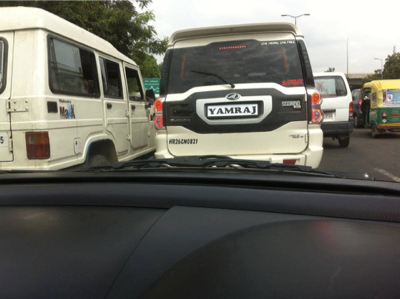

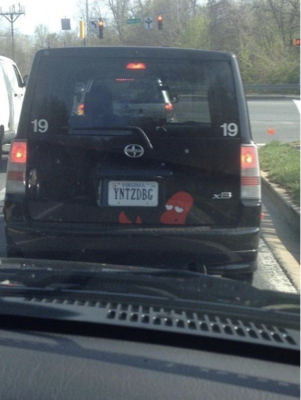


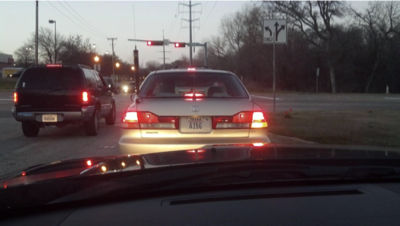

##Our Data

We found a dataset of license plates and corresponding bounding box labels here: https://www.kaggle.com/andrewmvd/car-plate-detection

Unfortunately, this data is not all dashcam data, but there are certainly some data points that represent the data we want, so our model still may be able to learn how to identify license plates from this point of view.

Note: The dataset had some less than desirable pictures, so we removed about ~60 data points. The reasons for removal could be many things, some of the pictures quite literally did not have license plates, some other ones had multiple license plates, and some pictures were so bad that the license plate was hard to read for us as humans. We figure if we can't read it ourselves, we shouldn't try to train the computer to do it.

#Data Collection/Setup

All of these cells are set up to import the data and set up variables for the machine learning model.

The more important things to note are:


*   `X` holds the images after being scaled down to (224, 224)
*   `Y` holds the bounding box information (y_max, y_min, etc) after being adjusted to fit into the (224, 224) image

*   `photos` holds the photos in their original dimensions
*   `bounds` holds the bounding box information in original dimensions



In [ ]:
import os
from google.colab import drive
drive.mount("/content/drive")
working_dir = '/content/drive/My Drive/LicensePlateData'

Mounted at /content/drive


In [ ]:
cd '$working_dir'

/content/drive/My Drive/LicensePlateData


In [ ]:
ls

annotations/  images/


In [ ]:
import glob
import random
from matplotlib import pyplot as plt


all_images = glob.glob(f'images/*.png')
all_images.sort()

all_xmls = glob.glob(f'annotations/*.xml')
all_xmls.sort()

In [ ]:
# Function to crop new picture according to bounding box
def crop_picture(img, bounds, padding=0):
  # Bounds should be in the format
  # [xmin, ymin, xmax, ymax]
  xmin, ymin, xmax, ymax = bounds[0], bounds[1], bounds[2], bounds[3]

  return img[ymin-padding:ymax+padding, xmin-padding:xmax+padding, :]

In [ ]:
import cv2
import numpy as np
from lxml import etree

photos = []
bounds = []

X = []
Y = []

IMAGE_SIZE = 224

# This method calculates the new bounding box dimensions for the resized image
def parse_xml_resized(xml_path):
  data = etree.parse(xml_path)

  for elt in data.xpath('size'):
    width = int(elt.xpath('width')[0].text)
    height = int(elt.xpath('height')[0].text)

  for elt in data.xpath('object/bndbox'):
    xmin = int(elt.xpath('xmin')[0].text) / (width / IMAGE_SIZE)
    xmax = int(elt.xpath('xmax')[0].text) / (width / IMAGE_SIZE)
    ymin = int(elt.xpath('ymin')[0].text) / (height / IMAGE_SIZE)
    ymax = int(elt.xpath('ymax')[0].text) / (height / IMAGE_SIZE)

    return [int(xmin), int(ymin), int(xmax), int(ymax)]

# This method simply pulls out the original bounding box dimensions
def parse_xml(xml_path):
  data = etree.parse(xml_path)

  for elt in data.xpath('size'):
    width = int(elt.xpath('width')[0].text)
    height = int(elt.xpath('height')[0].text)

  for elt in data.xpath('object/bndbox'):
    xmin = int(elt.xpath('xmin')[0].text)
    xmax = int(elt.xpath('xmax')[0].text)
    ymin = int(elt.xpath('ymin')[0].text)
    ymax = int(elt.xpath('ymax')[0].text)

    return [int(xmin), int(ymin), int(xmax), int(ymax), int(width), int(height)]


for i in range(len(all_images)):
  # Processing and storing image
  image = cv2.imread(all_images[i])
  image_resized = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

  photos.append(np.array(image))
  X.append(np.array(image_resized))

  # Handling the bounding box information
  Y.append(np.array(parse_xml_resized(all_xmls[i])))
  bounds.append(np.array(parse_xml(all_xmls[i])))
  # print(all_images[i], all_xmls[i])

The below cell just displays a random photo in original dimensions with the bounding box drawn on top

NOTE: There were some weird instances where the blue lines appeared to have stayed on the photos even through training the model. It might be best rerun the data collection after using this, not sure though. This applies to the other cells that show the picture along with the bounding box as well.

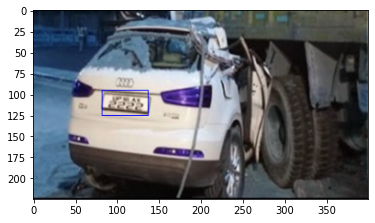

In [ ]:
# Displaying ORIGINAL DATA AND BOUNDS
r = random.randint(0, len(photos))
image = cv2.rectangle(photos[r],(bounds[r][0],bounds[r][1]),(bounds[r][2],bounds[r][3]),(0, 0, 255))
plt.imshow(image)
plt.show()


In [ ]:
Xa = np.array(X)
Ya = np.array(Y)

The below cell just displays a random photo in the (224, 224) dimensions with the bounding box drawn on top

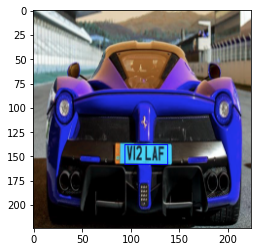

In [ ]:
# Displaying RESHAPED DATA AND BOUNDS
r = random.randint(0, Xa.shape[0])
image = cv2.rectangle(Xa[r],(Ya[r][0],Ya[r][1]),(Ya[r][2],Ya[r][3]),(0, 0, 255))
plt.imshow(image)
plt.show()

In [ ]:
print(Xa.shape)
print(Ya.shape)

(371, 224, 224, 3)
(371, 4)


In [ ]:
# Normalizing
Xn = Xa / 255
Yn = Ya / IMAGE_SIZE

#Model Building and Training

The code below sets up our training split, builds the model, and trains it!


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(Xn, Yn, test_size=0.1)

For our model, we decided on using a VGG16 layer to begin after reading on how this type of layer has shown itself to perform well on image recognition tasks. Past that, we are just using a Flatten layer and several Densely connected layers to add plenty of parameters for the model to train. 

As for activation functions, we originally used mostly relu and sigmoid activations, but in our research we read about the swish function which was said to work well on image recognition models. After trying it, it seemed to work well, so we kept it.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.applications.vgg16 import VGG16

model = Sequential()

model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(Flatten())
model.add(Dense(128, activation="swish"))
model.add(Dense(128, activation="swish"))
model.add(Dense(64, activation="swish"))
model.add(Dense(16, activation="swish"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-7].trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_9 (Dense)              (None, 4)                

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [ ]:
train = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=50, batch_size=32, verbose=1)

Epoch 1/50
11/11 [==============================] - 45s 610ms/step - loss: 0.0807 - accuracy: 0.5518 - val_loss: 0.0771 - val_accuracy: 0.3947
Epoch 2/50
11/11 [==============================] - 1s 135ms/step - loss: 0.0553 - accuracy: 0.4854 - val_loss: 0.0146 - val_accuracy: 0.6053
Epoch 3/50
11/11 [==============================] - 1s 136ms/step - loss: 0.0180 - accuracy: 0.6250 - val_loss: 0.0119 - val_accuracy: 0.6316
Epoch 4/50
11/11 [==============================] - 1s 135ms/step - loss: 0.0114 - accuracy: 0.7853 - val_loss: 0.0065 - val_accuracy: 0.7895
Epoch 5/50
11/11 [==============================] - 1s 137ms/step - loss: 0.0065 - accuracy: 0.8141 - val_loss: 0.0062 - val_accuracy: 0.7368
Epoch 6/50
11/11 [==============================] - 1s 136ms/step - loss: 0.0047 - accuracy: 0.7960 - val_loss: 0.0062 - val_accuracy: 0.7105
Epoch 7/50
11/11 [==============================] - 1s 138ms/step - loss: 0.0040 - accuracy: 0.8433 - val_loss: 0.0038 - val_accuracy: 0.8684
Epoch

#Evaluation

This code below helps us judge what our model is predicting to get a better idea of what it is learning.

In [ ]:
Y_predictions = model.predict(X_test)
Y_predictions = Y_predictions * IMAGE_SIZE
Y_predictions = Y_predictions.astype(int)

The cell below picks a random image and shows our models prediction of the bounding box
Then the next cell shows the image specifically bounded by our predictions.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


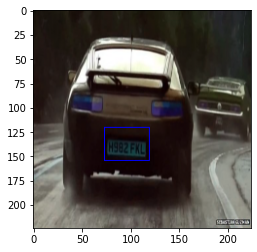

34


In [ ]:
# Displaying Predictions
r = random.randint(0, X_test.shape[0]-1)
predicted_bounds = Y_predictions[r]
image = cv2.rectangle(X_test[r],(predicted_bounds[0],predicted_bounds[1]),(predicted_bounds[2],predicted_bounds[3]),(0, 0, 255))
plt.imshow(image)
plt.show()
print(r)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


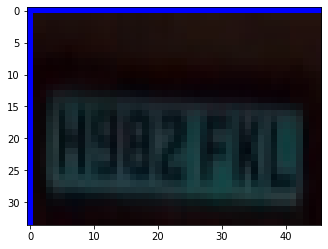

In [ ]:
croped = crop_picture(image, predicted_bounds)
plt.imshow(croped)

#Reading the license plates

Here we are using Python-tesseract which is simply a wrapper for Google's Tesseract-OCR engine. It will allow us to perform some OCR without having to train our own model for it. We figured this would make our lives a lot easier since OCR was not the focus of our project.

Then we use that OCR to process our cropped images of the license plates.

In [ ]:
!pip install pytesseract
!sudo apt install tesseract-ocr

Predicted text:  No Text Found


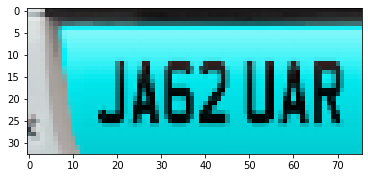

In [ ]:
import pytesseract
from PIL import Image


# Choosing random photo from X_test to display and process
r = random.randint(0, X_test.shape[0]-1)
license_plate = crop_picture(X_test[r], np.array(Y_predictions[r])).astype(float)

config = ('-l eng --oem 1 --psm 3')

license_plate_corrected = (license_plate * 255).astype(np.uint8)


predicted_text = pytesseract.image_to_string(license_plate_corrected, config=config)

output_text = predicted_text if not predicted_text.isspace() else "No Text Found"

print("Predicted text: ", output_text)
plt.imshow(license_plate_corrected)

So this didn't work very well! 
Hopefully this is because the picture has been resized so the ratios are odd.

Let's try taking the predicted bounds for a given photo in the dataset, then recalculate these predicted bounds for the 

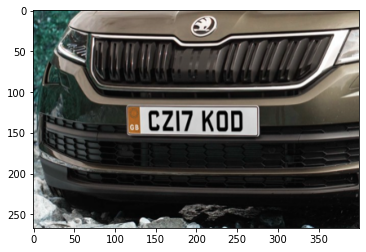

In [ ]:
picIndex = 9
# Reading the photo from the directory
photo = cv2.imread(all_images[picIndex])

plt.imshow(photo)

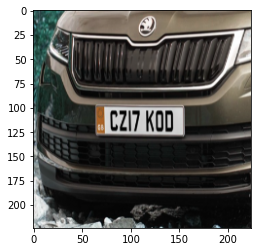

In [ ]:
# Its corresponding resized picture data should be in Xn at the same index
resized = Xn[picIndex]

plt.imshow(resized)

In [ ]:
# Predicting on all Xn
full_predictions = model.predict(Xn)

# Predictions need to be scaled back up
scaled_predictions = full_predictions * IMAGE_SIZE
scaled_predictions[picIndex]

array([ 65.60031,  97.63643, 152.12723, 131.0292 ], dtype=float32)

In [ ]:
# Now to try and scale these predictions for the original photo
prediction_proportions = scaled_predictions[picIndex] / IMAGE_SIZE

width, height = photo.shape[1], photo.shape[0]
print(width, height)
proper_prediction = [prediction_proportions[0] * width,
                     prediction_proportions[1] * height,
                     prediction_proportions[2] * width,
                     prediction_proportions[3] * height]

proper_prediction = np.array(proper_prediction, dtype=int)
proper_prediction

400 267


array([117, 116, 271, 156])

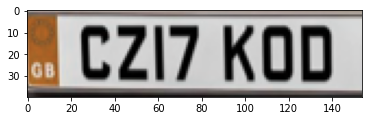

In [ ]:
# Now lets take a look at the cropped original photo by our adjusted bounding box
cropped_photo = crop_picture(photo, proper_prediction)

# NOTE: There is some padding 
plt.imshow(cropped_photo)

Much better! Lets try the OCR now

Predicted text:  "CZI7 KOD



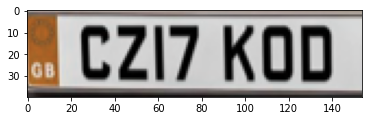

In [ ]:
predicted_text = pytesseract.image_to_string(cropped_photo, config=config)
output_text = predicted_text if not predicted_text.isspace() else "No Text Found"

print("Predicted text: ", output_text)
plt.imshow(cropped_photo)

Not bad!

Of course, this is just an example of where it is working pretty well. Right now it seems that PyTesseract is struggling to recognize a lot of letters/numbers from our images. However, our model is predicting the location of license plates quite well!

Moving forward, we definitely would like to improve our model more, but that honestly might take just having more/better data. The dataset we used is far from professional, many of the photos were not from the point of view we were designing our model for, but the we hope the data will still help the model learn how to identify the location of license plates. 